# Исследование объявлений о продаже квартир

У меня есть данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Моя задача — научиться определять рыночную стоимость объектов недвижимости и установить параметры для построения автоматизированной системы, которая отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных: первые вписаны пользователем, вторые — получены автоматически на основе картографических данных, например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('../datasets/real_estate_data.csv', sep='\t')

In [4]:
print(data.iloc[0])
data.info()

total_images                             20
last_price                       13000000.0
total_area                            108.0
first_day_exposition    2019-03-07T00:00:00
rooms                                     3
ceiling_height                          2.7
floors_total                           16.0
living_area                            51.0
floor                                     8
is_apartment                            NaN
studio                                False
open_plan                             False
kitchen_area                           25.0
balcony                                 NaN
locality_name               Санкт-Петербург
airports_nearest                    18863.0
cityCenters_nearest                 16028.0
parks_around3000                        1.0
parks_nearest                         482.0
ponds_around3000                        2.0
ponds_nearest                         755.0
days_exposition                         NaN
Name: 0, dtype: object
<class 'p

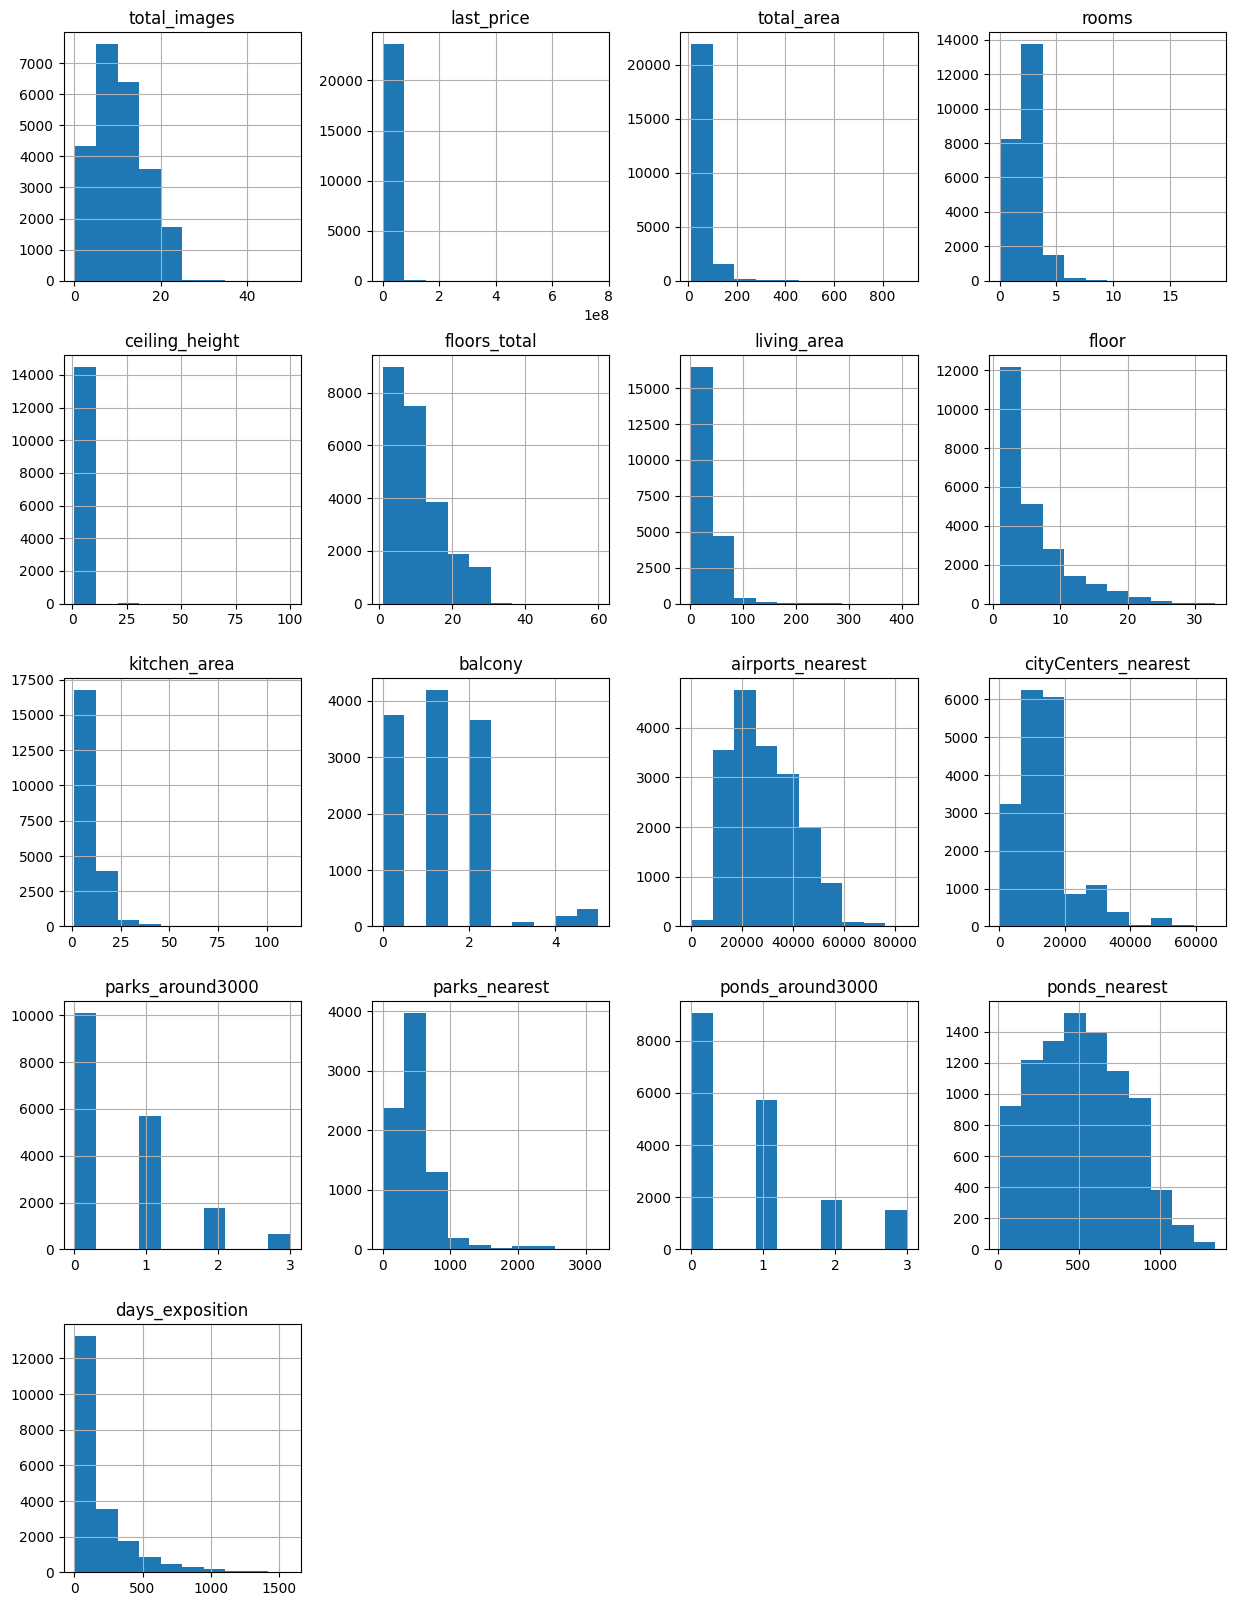

In [5]:
data.hist(figsize=(15, 20))
plt.show()

<div class="alert alert-block alert-info">
    
Промежуточный вывод:
- Я обнаружил пропущенные значения, с которыми нужно что-то сделать.
</div>

### Предобработка данных

In [6]:
data.head(1)
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


In [7]:
data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna(False)
data['floors_total'].fillna(data['floor'], inplace=True)
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)
data['airports_nearest'] = data['airports_nearest'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_nearest'] = data['parks_nearest'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)
data['days_exposition'] = data['days_exposition'].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [8]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

In [9]:
data['floors_total'] = data['floors_total'].astype('int')

In [10]:
data['last_price'] = data['last_price'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['airports_nearest'] = data['airports_nearest'].astype('int')
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['parks_nearest'] = data['parks_nearest'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['ponds_nearest'] = data['ponds_nearest'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [11]:
data.info()

data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'городской посёлок')
data['locality_name'] = data['locality_name'].str.replace('городской посёлок', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок', 'коттеджный посёлок')
data['locality_name'] = data['locality_name'].str.replace('коттеджный посёлок', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('поселок', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('посёлок городского типа', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('посёлок при железнодорожной станции', 'посёлок станции')

data['locality_name'].sort_values().unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка

In [12]:
print(data.describe())
print(data['ceiling_height'].quantile([.05, .95]))
print(data.query('(ceiling_height > 0) & (ceiling_height < 6.55)').count()/data['ceiling_height'].count())
print(data['ceiling_height'].mean() + data['ceiling_height'].std() * 3)
print(data['ceiling_height'].mean())
data['ceiling_height'][data['ceiling_height'] > 6.55] = 0
print(data.describe())

       total_images    last_price    total_area  \
count  23699.000000  2.369900e+04  23699.000000   
mean       9.858475  6.541549e+06     60.348651   
min        0.000000  1.219000e+04     12.000000   
25%        6.000000  3.400000e+06     40.000000   
50%        9.000000  4.650000e+06     52.000000   
75%       14.000000  6.800000e+06     69.900000   
max       50.000000  7.630000e+08    900.000000   
std        5.682529  1.088701e+07     35.654083   

                first_day_exposition         rooms  ceiling_height  \
count                          23699  23699.000000    14504.000000   
mean   2017-11-08 21:55:18.975484160      2.070636        2.771499   
min              2014-11-27 00:00:00      0.000000        1.000000   
25%              2017-05-12 12:00:00      1.000000        2.520000   
50%              2017-12-12 00:00:00      2.000000        2.650000   
75%              2018-08-26 00:00:00      3.000000        2.800000   
max              2019-05-03 00:00:00     19.000000

C:\Users\illif\AppData\Local\Temp\ipykernel_5504\1162190799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ceiling_height'][data['ceiling_height'] > 6.55] = 0


<div class="alert alert-block alert-info">

Я обнаружил, что в столбце `ceiling_height` максимальное значение равно 100, что является высотой потолков и, очевидно, аномалией.

</div>

In [13]:
data[data.duplicated()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


<div class="alert alert-block alert-info">
    
Промежуточный вывод:
- Я изменил типы данных и заменил пропуски там, где это было возможно.
- Я устранил неявные дубликаты в названиях населённых пунктов.
- Я убрал аномалии.
- Я проверил данные на наличие явных дубликатов.
</div>

### Посчитайте и добавьте в таблицу новые столбцы

In [14]:
data['price_square_meter'] = data['last_price'] / data['total_area']
data['day_of_the_week'] = data['first_day_exposition'].dt.dayofweek
data['month_of_publication'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year_of_publication'] = pd.DatetimeIndex(data['first_day_exposition']).year

def type_of_floor(row):
    if row['floor'] == row['floors_total']:
        return 'last'
    elif row['floor'] == 1:
        return 'first'
    else:
        return 'other'
data['type_of_floor'] = data.apply(type_of_floor, axis=1)
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).astype(int)

<div class="alert alert-block alert-info">

Промежуточный вывод:
- Я добавил новые столбцы.
</div>

### Проведите исследовательский анализ данных

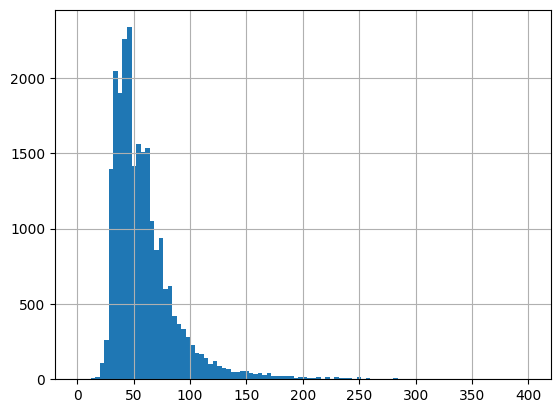

In [15]:
import matplotlib.pyplot as plt
data['total_area'].hist(bins=100,range = (0, 400))
plt.show()

<div class="alert alert-block alert-info">

Я обнаружил, что общая площадь, в основном, колеблется от 30 кв.м до 80 кв.м.
</div>

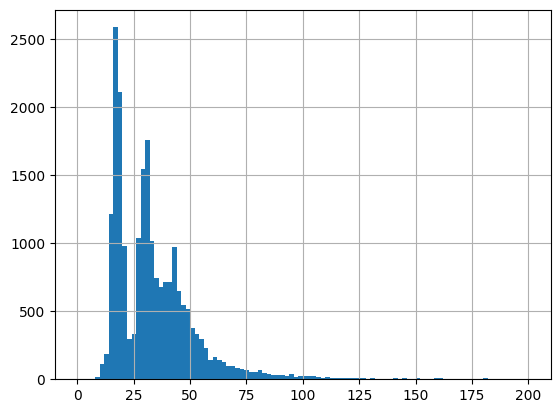

In [16]:
data['living_area'].hist(bins=100,range = (0, 200))
plt.show()

<div class="alert alert-block alert-info">

Я обнаружил, что жилая площадь, в основном, колеблется от 13 до 50 кв.м.
</div>

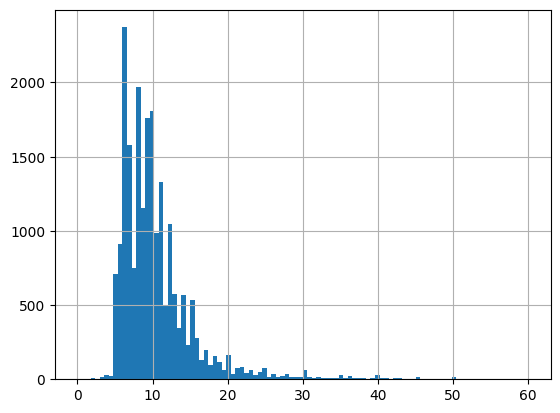

In [17]:
data['kitchen_area'].hist(bins=100,range = (0, 60))
plt.show()

<div class="alert alert-block alert-info">

Я обнаружил, что площадь кухни, в основном, колеблется от 5 до 15 кв.м.
</div>

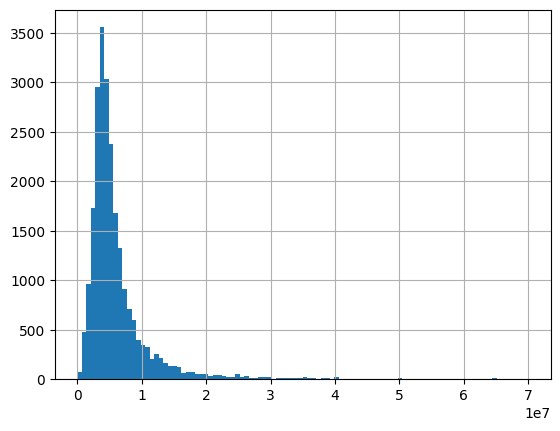

In [18]:
data['last_price'].hist(bins=100,range = (0, 70000000))
plt.show()

<div class="alert alert-block alert-info">

Я обнаружил, что цена, в основном, колеблется от 1 до 10 млн. руб.
</div>

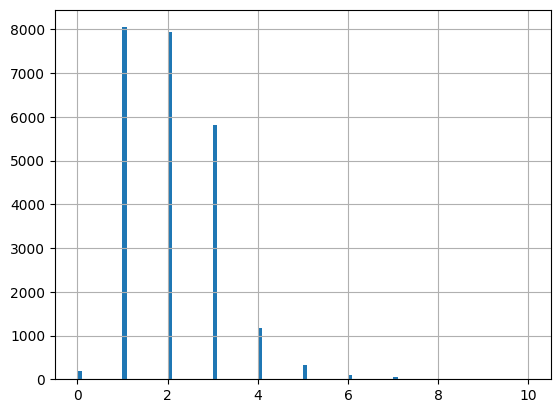

In [19]:
data['rooms'].hist(bins=100,range = (0, 10))
plt.show()

<div class="alert alert-block alert-info">
Я обнаружил, что число комнат, в основном, колеблется от 1 до 4.
</div>

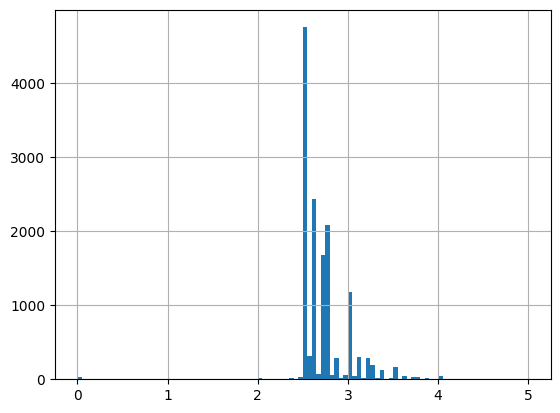

In [20]:
data['ceiling_height'].hist(bins=100,range = (0, 5))
plt.show()

<div class="alert alert-block alert-info">
Я обнаружил, что высота потолков колеблется от 2,5 до 3 м.
</div>

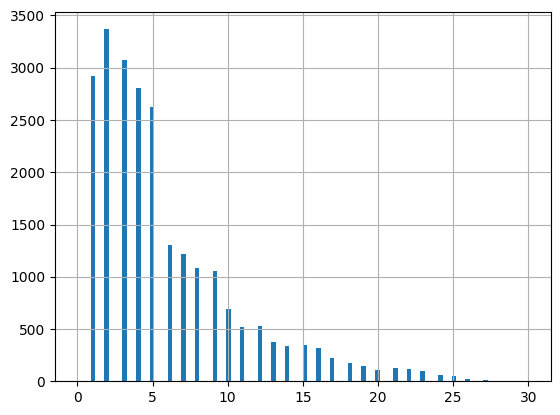

In [21]:
data['floor'].hist(bins=100,range = (0, 30))
plt.show()

<div class="alert alert-block alert-info">
Я обнаружил, что этажи, в основном, колеблются от 1 до 5.
</div>

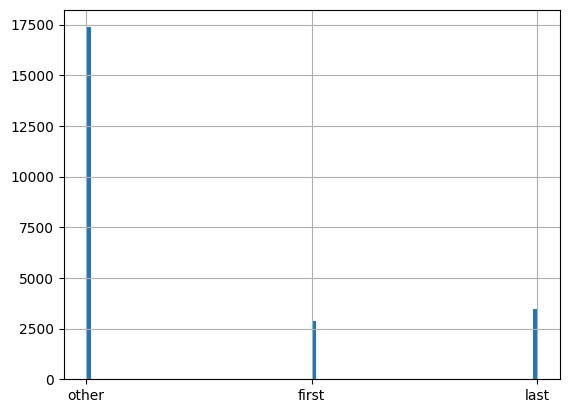

In [22]:
data['type_of_floor'].hist(bins=100)
plt.show()

<div class="alert alert-block alert-info">
Я обнаружил, что тип этажа, в основном, не первый и не последний.
</div>

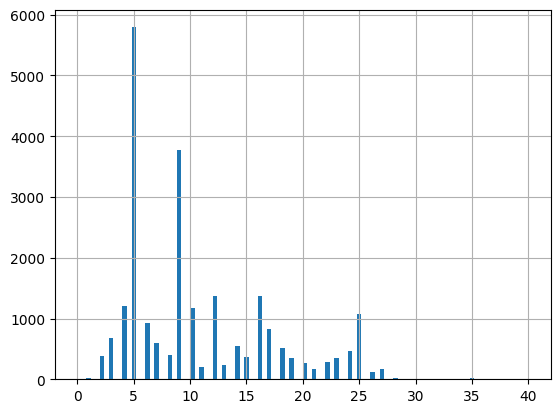

In [23]:
data['floors_total'].hist(bins=100,range = (0, 40))
plt.show()

<div class="alert alert-block alert-info">
Я обнаружил, что количество этажей в доме, в основном, равно 5 или 9.
</div>

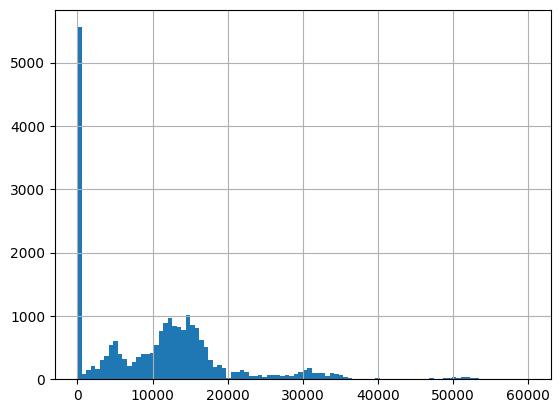

In [24]:
data['cityCenters_nearest'].hist(bins=100,range = (0, 60000))
plt.show()

<div class="alert alert-block alert-info">
Я обнаружил, что расстояние до центра города, в основном, равно 0 м.
</div>

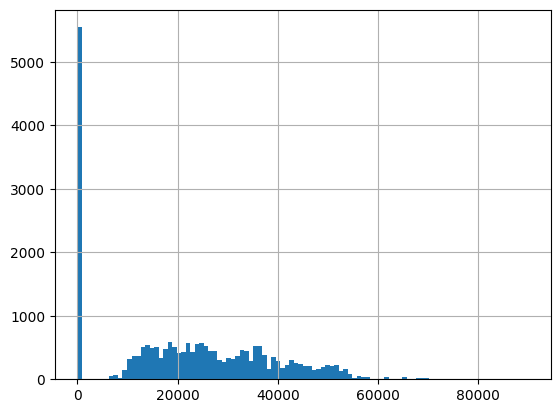

In [25]:
data['airports_nearest'].hist(bins=100,range = (0, 90000))
plt.show()

<div class="alert alert-block alert-info">
Я обнаружил, что расстояние до ближайшего аэропорта, в основном, колеблется от 10 до 40 км.
</div>

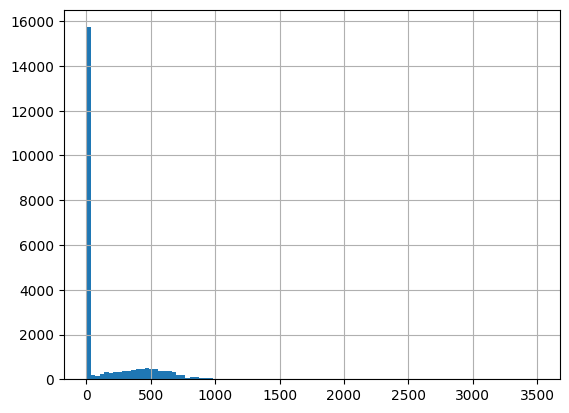

In [26]:
data['parks_nearest'].hist(bins=100,range = (0, 3500))
plt.show()

<div class="alert alert-block alert-info">
Я обнаружил, что расстояние до ближайшего парка, в основном, не превышает 1 км.
</div>

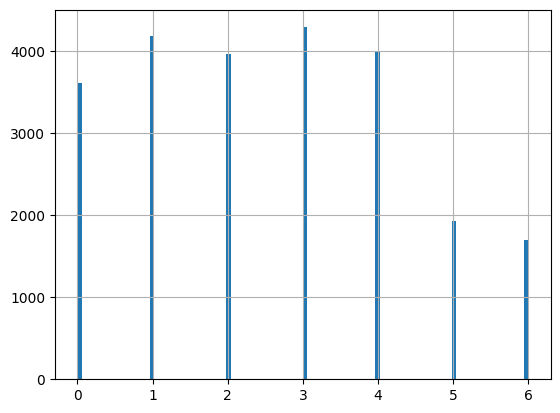

In [27]:
data['day_of_the_week'].hist(bins=100)
plt.show()

<div class="alert alert-block alert-info">
Я обнаружил, что объявления, в основном, публикуются по будням.
</div>

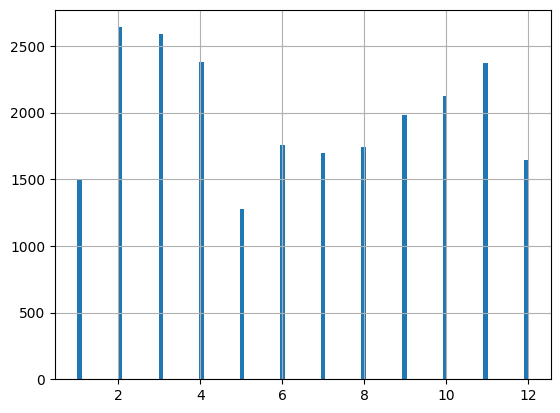

In [28]:
data['month_of_publication'].hist(bins=100)
plt.show()

<div class="alert alert-block alert-info">
Я обнаружил, что в январе и мае объявления публикуются чуть реже, чем в остальные месяцы.
</div>

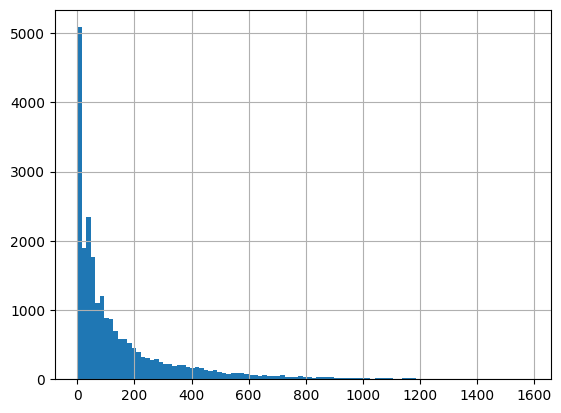

156.60884425503187
74.0


In [29]:
data['days_exposition'].hist(bins=100)
plt.show()
print(data['days_exposition'].mean())
print(data['days_exposition'].median())

<div class="alert alert-block alert-info">
Я обнаружил, что продажа обычно занимает 95 дней. Если продажа занимает меньше 95 дней, то её можно считать быстрой, а если больше 95 дней - долгой.
</div>

In [30]:
data['days_exposition'].describe()

count    23699.000000
mean       156.608844
std        213.546873
min          0.000000
25%         22.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

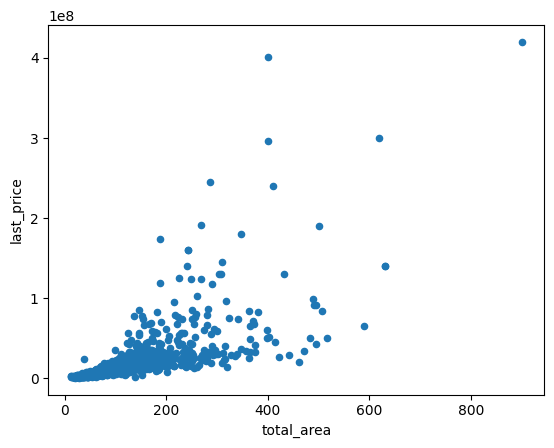

0.6536750579657244


In [31]:
data.pivot_table(index='total_area', values='last_price').reset_index().plot.scatter(x='total_area', y='last_price')
plt.show()
print(data['total_area'].corr(data['last_price']))

<div class="alert alert-block alert-info">
Я обнаружил, что чем больше общая площадь, тем дороже квартира. Это прямая зависимость.
</div>

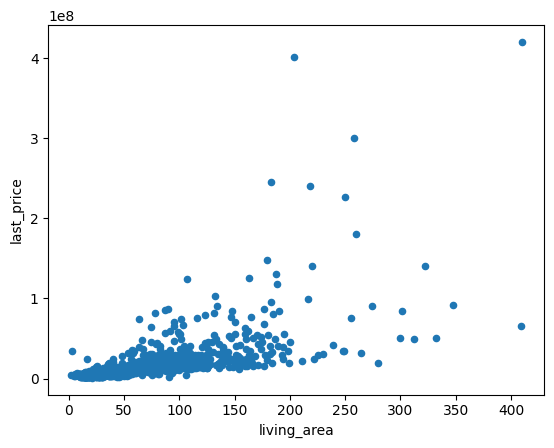

0.5664915336952648


In [32]:
data.pivot_table(index='living_area', values='last_price').reset_index().plot.scatter(x='living_area', y='last_price')
plt.show()
print(data['living_area'].corr(data['last_price']))

<div class="alert alert-block alert-info">
Я обнаружил, что чем больше жилая площадь, тем дороже квартира. Это прямая зависимость.
</div>

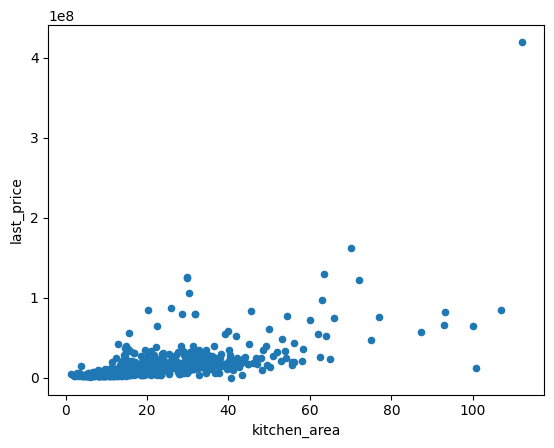

0.5198690130216388


In [33]:
data.pivot_table(index='kitchen_area', values='last_price').reset_index().plot.scatter(x='kitchen_area', y='last_price')
plt.show()
print(data['kitchen_area'].corr(data['last_price']))

<div class="alert alert-block alert-info">
Я обнаружил, что чем больше площадь кухни, тем дороже квартира. Это прямая зависимость.
</div>

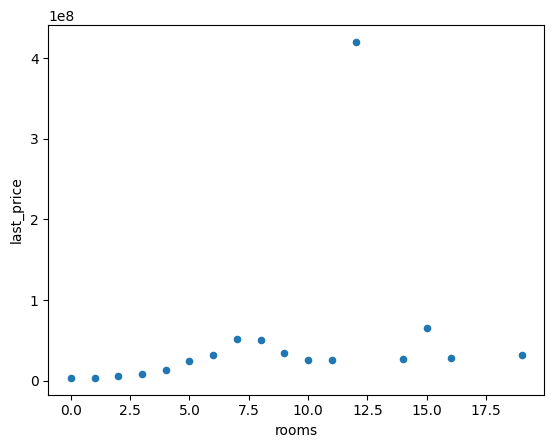

0.36334284996489546


In [34]:
data.pivot_table(index='rooms', values='last_price').reset_index().plot.scatter(x='rooms', y='last_price')
plt.show()
print(data['rooms'].corr(data['last_price']))

<div class="alert alert-block alert-info">
Я обнаружил, что чем больше комнат, тем дороже квартира. Это прямая зависимость.
</div>

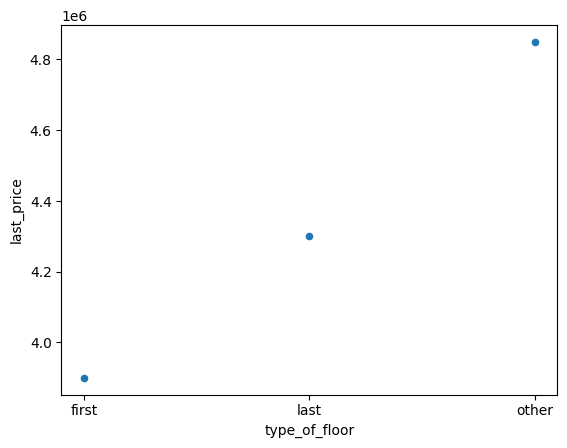

In [35]:
data.pivot_table(index='type_of_floor', values='last_price', aggfunc='median').reset_index().plot.scatter(x='type_of_floor', y='last_price')
plt.show()

<div class="alert alert-block alert-info">
Я обнаружил, что квартиры на первом и последнем этаже обычно дешевле.
</div>

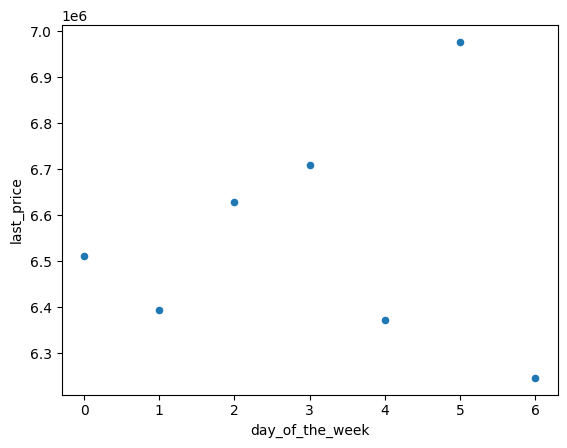

0.0015501452176215438


In [36]:
data.pivot_table(index='day_of_the_week', values='last_price').reset_index().plot.scatter(x='day_of_the_week', y='last_price')
plt.show()
print(data['day_of_the_week'].corr(data['last_price']))

<div class="alert alert-block alert-info">
Я обнаружил, что день публикации объявления никак не влияет на стоимость квартиры.
</div>

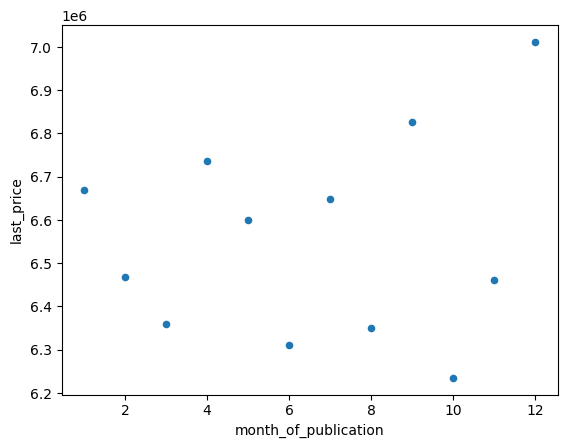

0.002779128750739724


In [37]:
data.pivot_table(index='month_of_publication', values='last_price').reset_index().plot.scatter(x='month_of_publication', y='last_price')
plt.show()
print(data['month_of_publication'].corr(data['last_price']))

<div class="alert alert-block alert-info">
Я считаю, что месяц публикации объявления никак не влияет на стоимость квартиры.
</div>

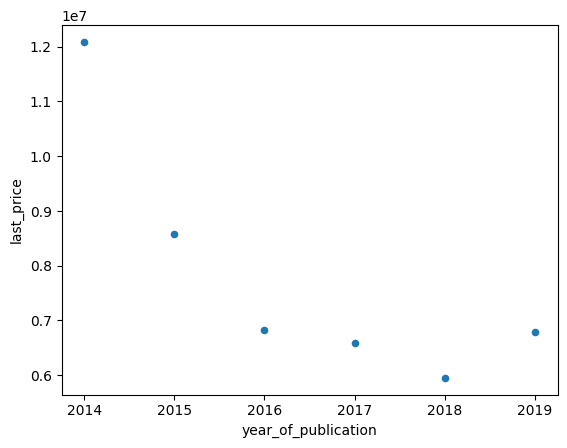

-0.04308903619950858


In [38]:
data.pivot_table(index='year_of_publication', values='last_price').reset_index().plot.scatter(x='year_of_publication', y='last_price')
plt.show()
print(data['year_of_publication'].corr(data['last_price']))

<div class="alert alert-block alert-info">
Я считаю, что год публикации объявления никак не влияет на стоимость квартиры.
</div>

<div class="alert alert-block alert-info">
Если я рассмотрю динамику цены и общей площади продаваемых квартир, то там самая большая корреляция. То есть общая площадь оказывает самое большое влияние на стоимость квартиры.
</div>

In [39]:
print(data['locality_name'].value_counts().head(10))
print(data.loc[data['locality_name']=='Санкт-Петербург','price_square_meter'].mean())
print(data.loc[data['locality_name']=='посёлок Мурино','price_square_meter'].mean())
print(data.loc[data['locality_name']=='посёлок Шушары','price_square_meter'].mean())
print(data.loc[data['locality_name']=='Всеволожск','price_square_meter'].mean())
print(data.loc[data['locality_name']=='Пушкин','price_square_meter'].mean())
print(data.loc[data['locality_name']=='Колпино','price_square_meter'].mean())
print(data.loc[data['locality_name']=='посёлок Парголово','price_square_meter'].mean())
print(data.loc[data['locality_name']=='Гатчина','price_square_meter'].mean())
print(data.loc[data['locality_name']=='деревня Кудрово','price_square_meter'].mean())
print(data.loc[data['locality_name']=='Выборг','price_square_meter'].mean())

locality_name
Санкт-Петербург      15721
посёлок Мурино         556
посёлок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: count, dtype: int64
114849.00879387381
85681.76260114639
78677.3642167513
68654.4739860316
103125.81929072196
75424.57909803945
90175.91345801107
68746.14676333922
92473.54757579972
58141.90915331862


In [40]:
data.groupby('locality_name').agg({'locality_name':'count', 'price_square_meter':'median'})

,locality_name,price_square_meter
locality_name,,
Бокситогорск,16,17361.111111
Волосово,36,39906.323185
Волхов,111,35000.000000
Всеволожск,398,65789.473684
Выборг,237,58158.319871
...,...,...
село Путилово,2,39921.758208
село Рождествено,3,35897.435897
село Русско-Высоцкое,9,52060.737527


In [41]:
data.groupby('locality_name').agg({'last_price':'count', 'price_square_meter':'median'}).sort_values(by = 'last_price',ascending=False).head(10)

,last_price,price_square_meter
locality_name,,
Санкт-Петербург,15721,104761.904762
посёлок Мурино,556,85878.462169
посёлок Шушары,440,76876.172608
Всеволожск,398,65789.473684
Пушкин,369,100000.000000
Колпино,338,74723.748474
посёлок Парголово,327,91642.857143
Гатчина,307,67796.610169
деревня Кудрово,299,91860.465116


<div class="alert alert-block alert-info">
Я обнаружил, что самая высокая средняя стоимость 1 квадратного метра в Санкт-Петербурге составляет 104761.904762 руб. С другой стороны, самая низкая средняя стоимость 1 квадратного метра находится в Выборге и составляет 58158.319871 руб.
</div>

622670.5881240134


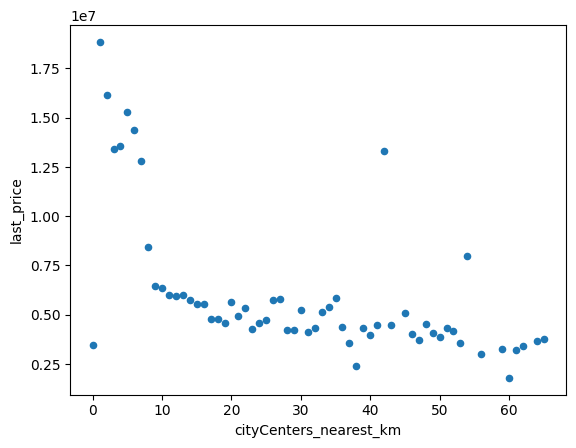

In [42]:
print(data['last_price'].mean()/data['cityCenters_nearest_km'].mean())
data.pivot_table(index='cityCenters_nearest_km', values='last_price').reset_index().plot.scatter(x='cityCenters_nearest_km', y='last_price')
plt.show()

728925.5299476096


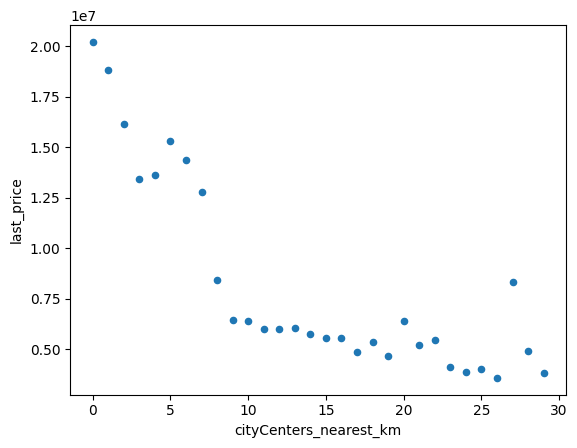

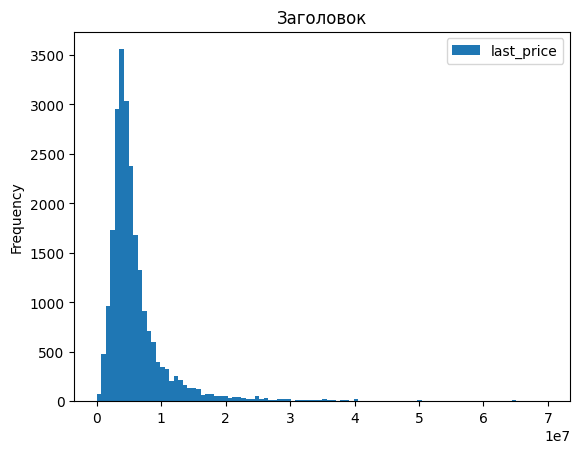

In [43]:
print(data.query('locality_name == "Санкт-Петербург"')['last_price'].mean()/data.query('locality_name == "Санкт-Петербург"')['cityCenters_nearest_km'].mean())
data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km', values='last_price').reset_index().plot.scatter(x='cityCenters_nearest_km', y='last_price')
plt.show()
data.plot(x="cityCenters_nearest_km", y="last_price", kind='hist', bins=100,range = (0, 70000000), title = 'Заголовок');
plt.show()

<div class="alert alert-block alert-info">
Я обнаружил, что средняя цена каждого километра до центра составляет 728926 руб. Чем ближе к центру, тем квартиры дороже.
</div>

<div class="alert alert-block alert-info">
    
Промежуточный вывод:
- Я изучил параметры объектов и узнал, как быстро продавались квартиры и какие факторы больше всего влияют на общую стоимость объекта.
- Я посчитал среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.
- Я вычислил среднюю цену каждого километра до центра.
</div>

### Общий вывод:

<div class="alert alert-block alert-info">
    
- Я изучил проект, нашёл пропущенные значения и заменил их там, где это возможно.
- Также я изменил тип данных некоторых столбцов.
- Затем я избавился от неявных дубликатов в названиях населённых пунктов и от аномалий.
- Я добавил несколько новых столбцов.
- Я выяснил, что продажи, у которых время размещения объявления менее 1,5 месяца, можно считать быстрыми. А продажи, у которых время размещения объявления более 8 месяцев, можно считать необычно долгими.
- Я узнал, что на стоимость объекта больше всего влияет общая площадь, так как коэффициент корреляции Пирсона составляет 0,65.
- Я выяснил, что квартиры дешевле на первом и последнем этажах.
- Я узнал, что самая высокая средняя стоимость 1 м2 в Санкт-Петербурге составляет 104762 руб. Самая низкая средняя стоимость 1 м2 в Выборге составляет 58158 руб.
- Я узнал, что в Санкт-Петербурге чем ближе квартиры к центру, тем они дороже за каждый километр на 728926 рублей.
    
---

Рекомендации для бизнеса отделу разработчиков:
- Так как в данных много пропущенных значений, то желательно сделать формы для подачи объявлений с обязательными полями для ceiling_height, living_area и kitchen_area.
</div>